In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import copy
import re
import time
import seaborn
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (5,3)

In [2]:
def save_fig(fn):
     plt.tight_layout()
     plt.savefig(fn, metadata={'CreationDate': None})

In [3]:
CONFIG = {}

CONFIG['DATA_FILE'] = "21_03_2022_idle_nodes.txt"

# The data file was generated using the following command (XXX is the user name)
# while true; do date +%s; echo -n "invokers: "; squeue -u XXX -t r -p lowprio -O nodelist -h | gawk '{print $1}' | paste -sd,; sinfo -h -p lowprio | grep idle; echo "----"; sleep 10s; done | tee -a log.txt

CONFIG['DATA_LATER_THAN'] = datetime(2022, 3, 21)
CONFIG['DATE_EARLIER_THAN'] = datetime(2022, 3, 22)

In [4]:
def expand(s):
    r = s.group().split("-")
    l, r = int(r[0]), int(r[1])
    s = []
    for i in range(l, r+1):
        s.append("%04d" % i)
    return ",".join(s)

idleness_records = []
max_node_id = 0

with open(CONFIG['DATA_FILE'], 'r') as log:
    # Read timestamp
    timestamp = log.readline()

    while timestamp:
        # Convert timestamp to integer
        timestamp = int(timestamp)

        ow_nodes = []

        # Read the list of OW invokers
        line = log.readline()
        line = line.split()
        if len(line) > 1:
            ow_nodes = line[1]
            ow_nodes = ow_nodes.split(",")
            ow_nodes = [int(x[1:]) for x in ow_nodes]

            if max(ow_nodes) > max_node_id:
                max_node_id = max(ow_nodes)

        idle_nodes = []

        line = log.readline()
        while line != "----\n":
            # Read the list of nodes
            line = line.split()
            type, record = line[4], line[5]

            # We are only interested in type "idle"
            if type == "idle":
                # Clean the record
                record = record[1:]
                if record[0] == "[":
                    record = record[1:-1]

                # Extract node ids
                record = re.sub("[0-9]{4}-[0-9]{4}", expand, record).split(",")
                idle_nodes = idle_nodes + list(map(lambda x: int(x), record))

                if max(idle_nodes) > max_node_id:
                    max_node_id = max(idle_nodes)
            
            line = log.readline()

        # We are only interested in certain timestamps
        if timestamp >= int(time.mktime(CONFIG['DATA_LATER_THAN'].timetuple())) and timestamp < int(time.mktime(CONFIG['DATE_EARLIER_THAN'].timetuple())):
            idleness_records.append({
                "timestamp" : datetime.fromtimestamp(timestamp),
                "idle_nodes" : idle_nodes,
                "ow_nodes" : ow_nodes
            })

        # Read the next timestamp
        timestamp = log.readline()

In [5]:
CONFIG['DATA_WIDTH'] = len(idleness_records)
CONFIG['DATA_HEIGHT'] = max_node_id + 1 # Some of the nodes were never idle in the measured period, so this number is less than the number of all the nodes in the cluster
CONFIG['MEASURE_DISTANCE'] = (idleness_records[-1]["timestamp"] - idleness_records[0]["timestamp"]).total_seconds() / (CONFIG['DATA_WIDTH'] - 1)

CONFIG['DATA_WIDTH'], CONFIG['DATA_HEIGHT'], CONFIG['MEASURE_DISTANCE']

(8091, 2296, 10.679357231149567)

In [6]:
RESOURCES = {}

In [7]:
# Convert df to a list of idle intervals
RESOURCES['initial_node_status'] = {}

# Create empty bitarrays for all nodes
for node in range(CONFIG['DATA_HEIGHT']):
    RESOURCES['initial_node_status'][node] = [0] * CONFIG['DATA_WIDTH']

for timepoint in range(CONFIG['DATA_WIDTH']):
    for node in idleness_records[timepoint]["idle_nodes"]:
        RESOURCES['initial_node_status'][node][timepoint] = 1
    for node in idleness_records[timepoint]["ow_nodes"]:
        RESOURCES['initial_node_status'][node][timepoint] = 2

In [8]:
RESOURCES['total_number_of_measurements'] = CONFIG['DATA_WIDTH'] * CONFIG['DATA_HEIGHT']
RESOURCES['total_number_of_measurements__busy'] = sum([RESOURCES['initial_node_status'][node].count(0) for node in range(CONFIG['DATA_HEIGHT'])])
RESOURCES['total_number_of_measurements__idle'] = \
    RESOURCES['total_number_of_measurements'] - RESOURCES['total_number_of_measurements__busy']
RESOURCES['share_of_measurements__busy'] = \
    RESOURCES['total_number_of_measurements__busy'] / RESOURCES['total_number_of_measurements']
RESOURCES['share_of_measurements__idle'] = \
    RESOURCES['total_number_of_measurements__idle'] / RESOURCES['total_number_of_measurements']

In [9]:
RESOURCES['share_of_measurements__idle']

0.0032133393795403076

# Question 1

## How much coverage we have?

In [10]:
MID_RESULTS = {}
MID_RESULTS['number_of_free_nodes_each_point'] = \
    [CONFIG['DATA_HEIGHT'] - item.count(0) for item in zip(*[RESOURCES['initial_node_status'][node] for node in range(CONFIG['DATA_HEIGHT'])])]

In [11]:
print(np.mean(MID_RESULTS['number_of_free_nodes_each_point']))

7.377827215424546


In [12]:
import copy

MID_RESULTS['simulation'] = {}
MID_RESULTS['simulation']['availability_status'] = copy.deepcopy(RESOURCES['initial_node_status'])
MID_RESULTS['simulation']['total_warmup_ready_time'] = sum([item.count(2) for item in zip(*[RESOURCES['initial_node_status'][node] for node in range(CONFIG['DATA_HEIGHT'])])])

In [13]:
print(MID_RESULTS['simulation']['total_warmup_ready_time']*CONFIG['MEASURE_DISTANCE'])

434788.67095179233


In [14]:
z = tuple(zip(*[MID_RESULTS['simulation']['availability_status'][node] for node in range(CONFIG['DATA_HEIGHT'])]))
MID_RESULTS['simulation']['status_summary'] = [[item.count(i) for item in z] for i in range(4)]

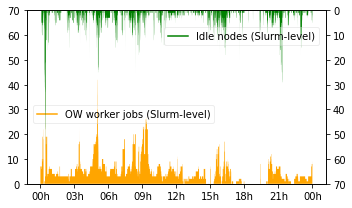

In [15]:
_, ax = plt.subplots()

plt.plot([], [], color='orange', label='OW worker jobs (Slurm-level)')
plt.stackplot(list(map(lambda x : x["timestamp"], idleness_records)), [MID_RESULTS['simulation']['status_summary'][2]], colors=['orange'])

# handles, labels = ax.get_legend_handles_labels()
# patch = patches.Patch(color='green', label='Idle nodes (Simulation)')
# handles.append(patch) 

ax.legend(loc=(0.02, 0.35), framealpha=0.35)

ax2 = ax.twinx()
ax2.set_ylim(0, 70)
ax2.invert_yaxis()

plt.plot([], [], color='green', label='Idle nodes (Slurm-level)')
plt.stackplot(list(map(lambda x : x["timestamp"], idleness_records)), MID_RESULTS['simulation']['status_summary'][1], colors=['green'])

ax2.legend(loc=(0.46, 0.8), framealpha=0.35)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))
ax.set_ylim(0, 70)
plt.xticks(rotation = 90)

save_fig("02 - Var model analysis - Slurm-level - Node statuses TS.pdf")
pass

In [16]:
print(np.quantile(MID_RESULTS['simulation']['status_summary'][2], 0.25))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][2], 0.5))
print(np.quantile(MID_RESULTS['simulation']['status_summary'][2], 0.75))
print(np.mean(MID_RESULTS['simulation']['status_summary'][2]))

2.0
4.0
6.0
5.031887282165369


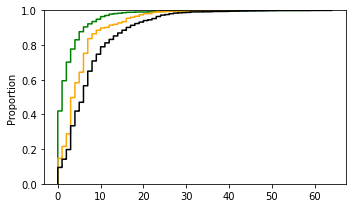

In [17]:
seaborn.ecdfplot(MID_RESULTS['simulation']['status_summary'][1], color = 'green')
seaborn.ecdfplot(MID_RESULTS['simulation']['status_summary'][2], color = 'orange')
seaborn.ecdfplot(MID_RESULTS['number_of_free_nodes_each_point'], color = 'black')

save_fig("02 - Var model analysis - Slurm-level - Node statuses CDF.pdf")
pass

In [18]:
print("Share of idle time used as ready or warmup:", MID_RESULTS['simulation']['total_warmup_ready_time']/RESOURCES['total_number_of_measurements__idle'])
print("Share of idle time not used:", 1 - MID_RESULTS['simulation']['total_warmup_ready_time']/RESOURCES['total_number_of_measurements__idle'])
print("Number of measurements where no OW worker was warming up or ready:", MID_RESULTS['simulation']['status_summary'][2].count(0))
print("Share of time where no OW worker was ready:", MID_RESULTS['simulation']['status_summary'][2].count(0)/CONFIG['DATA_WIDTH'])
print("Average number of warmup or ready nodes: ", (MID_RESULTS['simulation']['total_warmup_ready_time']/RESOURCES['total_number_of_measurements__idle']) * (sum(MID_RESULTS['number_of_free_nodes_each_point'])/CONFIG['DATA_WIDTH']))

Share of idle time used as ready or warmup: 0.6820283445572419
Share of idle time not used: 0.31797165544275807
Number of measurements where no OW worker was warming up or ready: 1184
Share of time where no OW worker was ready: 0.14633543443332098
Average number of warmup or ready nodes:  5.031887282165369
